In [ ]:
"""!pip install -q transformers
!pip install keras-tuner -q
!pip install visualkeras
!pip install pydot
!pip install graphviz
!pip install shap"""



import re
import numpy as np
import pandas as pd
import random
import tensorflow as tf
import torch
import matplotlib.pyplot as plt
import sys
from google.colab import files
from transformers import TFBertModel, BertTokenizer, BertConfig
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, classification_report
from keras.optimizers import Adam
from keras import utils
from keras.utils import to_categorical
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, Concatenate, AveragePooling2D, Dropout
from keras.regularizers import l2
from keras.callbacks import EarlyStopping
import shap


pd.set_option('display.max_colwidth', None)
np.set_printoptions(threshold=sys.maxsize)

In [ ]:
uploaded = files.upload()

Saving PAAC.txt to PAAC (3).txt
Saving Test.FASTA to Test (1).FASTA
Saving Train.FASTA to Train (1).FASTA


In [ ]:
tokenizer = BertTokenizer.from_pretrained("Rostlab/prot_bert_bfd", do_lower_case=False )
model = TFBertModel.from_pretrained("Rostlab/prot_bert_bfd", from_pt=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertMo

In [ ]:
uploaded_fasta_train = list(uploaded.keys())[2]
fasta_content_train = uploaded[uploaded_fasta_train].decode('utf-8')  # Decode the bytes to a string
print(uploaded_fasta_train)
print(len(fasta_content_train))
#print(fasta_content_train)

uploaded_fasta_test = list(uploaded.keys())[1]
fasta_content_test = uploaded[uploaded_fasta_test].decode('utf-8')  # Decode the bytes to a string
print(uploaded_fasta_test)
print(len(fasta_content_test))
#print(fasta_content_test)

Train (1).FASTA
26364
Test (1).FASTA
6591


## Data Preprocessing

In [ ]:
#Reading Train Dataset with FASTA format
sequences_train = {}
current_header_train = None
current_sequence_train = []

#Parse train
for line in fasta_content_train.split('\n'):
    line = line.strip()
    if line.startswith(">"):  # Header line
        if current_header_train is not None:
            sequences_train[current_header_train] = ''.join(current_sequence_train)
        current_header_train = line[1:]  # Remove the '>' character
        current_sequence_train = []
    else:
        current_sequence_train.append(line)

#Don't forget to add the last sequence
if current_header_train is not None:
    sequences_train[current_header_train] = ''.join(current_sequence_train)

labels_train = []

for header in sequences_train.keys():
    if "positive" in header:
        labels_train.append("positive")
    elif "negative" in header:
        labels_train.append("negative")

y_train = [label == 'positive' for label in labels_train]
print("Total number of positive train samples:", sum(y_train))
print("Total number of negative train samples:", len(y_train) - sum(y_train))
print("length of y_train:", len(y_train))
#print(y_train)

#----------------------------------------
print("--------------------------")

#Reading Test Dataset with FASTA format
sequences_test = {}
current_header_test = None
current_sequence_test = []

# Parse the FASTA content test
for line in fasta_content_test.split('\n'):
    line = line.strip()
    if line.startswith(">"):  # Header line
        if current_header_test is not None:
            sequences_test[current_header_test] = ''.join(current_sequence_test)
        current_header_test = line[1:]  # Remove the '>' character
        current_sequence_test = []
    else:
        current_sequence_test.append(line)

# Don't forget to add the last sequence
if current_header_test is not None:
    sequences_test[current_header_test] = ''.join(current_sequence_test)

# array that sequentially stores positive or negative values
labels_test = []

for header in sequences_test.keys():
    if "positive" in header:
        labels_test.append("positive")
    elif "negative" in header:
        labels_test.append("negative")

print("Total number of positive train samples:", sum(y_train))
print("Total number of negative train samples:", len(y_train) - sum(y_train))
y_test = [label == 'positive' for label in labels_test]
print("length of the y_test: ", len(y_test))
#print(y_test)


Toplam pozitif train örnek sayısı: 470
Toplam negatif train örnek sayısı: 318
length of y_train: 788
--------------------------
Toplam pozitif train örnek sayısı: 470
Toplam negatif train örnek sayısı: 318
length of the y_test:  197


In [ ]:
sequences_Example_train = []
length_train = []

for sequence in sequences_train.values():
    formatted_sequence = ' '.join(sequence)

    sequences_Example_train.append(formatted_sequence)
    length_train.append(len(sequence))

#print(length_train)
print("Min Train Sequence Length:", min(length_train))
print("Max Train Sequence Length:", max(length_train))
print("Train sequences:", sequences_Example_train)

sequences_Example_test = []
length_test = []

for sequence in sequences_test.values():
    formatted_sequence = ' '.join(sequence)
    sequences_Example_test.append(formatted_sequence)
    length_test.append(len(sequence))


#print(length_test)
print("Min Test Sequence Length:", min(length_test))
print("Max Test Sequence Length:",max(length_test))
print("Test sequences:", sequences_Example_test)

Min Train Sequence Length: 8
Max Train Sequence Length: 37
Train sequences: ['S S P G C Q P P A', 'P L P P A R N G G L', 'S L A D E A E V Y L', 'Y S W M D I S C W I', 'W A T L P L L C A R', 'L H H A F V D S I F', 'A L N F P G S Q K', 'F L I I W Q N T M', 'Q L M A F N H L I', 'K A R D P H S G H F V', 'H A C W P A F T V', 'S L L M W I T Q C F L', 'G L L F L H T R T', 'Y L N R H L H T W I', 'I S G G P R I S Y', 'K L L G P H V E G L', 'A L Y V D S L F F L', 'K L Y E E P L L K', 'Q E A P D V V A F V', 'M V K I S G G P R', 'A E E A A G I G I L', 'M E V D P I G H L Y', 'Q R P Y G Y D Q I M', 'T V S G N I L T I R', 'L L L D D L L V S I', 'F L K L D R E R A', 'E Y L Q L V F G I', 'K T L T S V F Q K', 'K A Q V S N E D C L', 'L L D R F L A T V', 'M P F A T P M E A E L', 'D L L S H A F F A', 'D Y P S L S A T D I', 'W L Q Y F P N P V', 'L L L G P L G P L', 'L L G A T C M F V', 'S E I W R D I D', 'C Y M E A V A L', 'C L Y G N V E K V', 'S L F E G I D I Y T', 'Y L A M P F A T P M E A E L A R R S L A'

In [ ]:
#Combining X and y by zipping them together
combined_data = list(zip(sequences_Example_train,y_train))
random.seed(42)
random.shuffle(combined_data)

#Seperate mixed X and y pairs
sequences_Example_train, y_train = zip(*combined_data)

print("Mixed X_train Sequences:", sequences_Example_train)
print("Mixed y_train Values:", y_train)


Mixed X_train Sequences: ('T K D T Y D A L H M Q A L P P', 'F T W E G L Y N V', 'R L D F N L I R V', 'A A A G F L F C V', 'S I I G R L L E V', 'V Y D F F V W L H Y', 'S P R P P L G S S L', 'A N D P I F V V L', 'F L Y D D N Q R V', 'A I Y K Q S Q H M', 'K E L E G I L L L', 'M L T N S C V K L', 'K A C D P H S G H F V', 'K T P P N P K H A', 'K A R D P H S G H F V', 'G V L L K E F T V S G N', 'V F H F M Q S L A L L M S P V', 'Q G Q H F L Q K V', 'Y L N T V Q P T C V', 'L L Y K L A D L I', 'I Q N L E R G Y R', 'R L M K H Y P G I', 'F V W L H Y Y S V', 'A P G S V L P R A L', 'E L L I R K L P F', 'G I G I L T V I L', 'Y L N R H L H T W I', 'R S R R V L Y P R', 'L N E E E R L I R H L F Q E K G Y N K E', 'D Y L R S V L E D F', 'D F M I Q G G D F', 'L I Y D S S L C D L', 'M L G T H T M E V', 'S L F R A V I T K', 'E V A P D A K S F', 'L P R W P P P Q L', 'K L F G V L R L K', 'A L V S I I K V', 'R L Q E D P P A G V', 'Q M R P V S R V L', 'K D L L E Q K R G R V D N Y C', 'K I F S E V T L K', 'T K A

In [ ]:
#Extracting feature embeddings for X_train
sequences_Example_train = [re.sub(r"[UZOB]", "X", sequence) for sequence in sequences_Example_train]
ids_train = tokenizer.batch_encode_plus(sequences_Example_train, add_special_tokens=True, padding=True, return_tensors="tf")
input_ids = ids_train['input_ids']
attention_mask = ids_train['attention_mask']
embedding = model(input_ids)[0]
embedding = np.asarray(embedding)
attention_mask = np.asarray(attention_mask)
X_train = []
for seq_num in range(len(embedding)):
    seq_len = (attention_mask[seq_num] == 1).sum()
    seq_emd = embedding[seq_num][1:seq_len-1]
    X_train.append(seq_emd)


#print(X_train)
print("Length of X_train:", len(X_train))


sequences_Example_test = [re.sub(r"[UZOB]", "X", sequence) for sequence in sequences_Example_test]
ids_test = tokenizer.batch_encode_plus(sequences_Example_test, add_special_tokens=True, padding=True, return_tensors="tf")

input_ids_test = ids_test['input_ids']
attention_mask_test = ids_test['attention_mask']
embedding_test = model(input_ids_test)[0]
embedding_test = np.asarray(embedding_test)
attention_mask_test = np.asarray(attention_mask_test)
X_test = []
for seq_num in range(len(embedding_test)):
    seq_len = (attention_mask_test[seq_num] == 1).sum()
    seq_emd = embedding_test[seq_num][1:seq_len-1]
    X_test.append(seq_emd)

#print(X_test)
print("Length of X_test:", len(X_test))




Length of X_train: 788
Length of X_test: 197


In [ ]:
#Adding new 1024 features by taking means and stdev for each sequence (1024 + 1024 = 2048 features for every sequence)

result_matrix_train = []
for i in range(len(X_train)):
    mean_matrix_train = np.mean(X_train[i], axis=0, keepdims=True)
    std_matrix_train = np.std(X_train[i], axis=0, keepdims=True)
    result_matrix_train.append(np.hstack((mean_matrix_train, std_matrix_train)) )

X_train_final = np.vstack(result_matrix_train)

print("Shape of new train features:", X_train_final.shape)


result_matrix_test = []
for i in range(len(X_test)):
    mean_matrix_test = np.mean(X_test[i], axis=0, keepdims=True)
    std_matrix_test = np.std(X_test[i], axis=0, keepdims=True)
    result_matrix_test.append(np.hstack((mean_matrix_test, std_matrix_test)) )

X_test_final = np.vstack(result_matrix_test)


print("Shape of new test features:", X_test_final.shape)



Shape of new train features: (788, 2048)
Shape of new test features: (197, 2048)


In [ ]:
mean_matrix_train.shape

(1, 1024)

## iTTCA-RF (Chemical) Features Extraction

In [ ]:
sequences_Example_train = [sequence.replace(" ", "") for sequence in sequences_Example_train]
fastas_train = sequences_Example_train

sequences_Example_test = [sequence.replace(" ", "") for sequence in sequences_Example_test]
fastas_test = sequences_Example_test

ittca_features_train = get_features(fastas_train)
ittca_features_test = get_features(fastas_test)
chemical_feature_names = get_feature_names()

print("There are 365 features for every sequence as you see below:")
print("Shape of chemical features in train set:", ittca_features_train.shape)
print("Shape of chemical features in test set:", ittca_features_test.shape)
print("Feature names:", chemical_feature_names)

Feature extraction...
Feature extraction...
There are 365 features for every sequence as you see below:
Shape of chemical features in train set: (788, 365)
Shape of chemical features in test set: (197, 365)
Feature names: ['AAC_A', 'AAC_C', 'AAC_D', 'AAC_E', 'AAC_F', 'AAC_G', 'AAC_H', 'AAC_I', 'AAC_K', 'AAC_L', 'AAC_M', 'AAC_N', 'AAC_P', 'AAC_Q', 'AAC_R', 'AAC_S', 'AAC_T', 'AAC_V', 'AAC_W', 'AAC_Y', 'CTDC Hydrophobicity c1', 'CTDC Hydrophobicity c2', 'CTDC Hydrophobicity c3', 'CTDT Hydrophobicity c1221', 'CTDT Hydrophobicity c1331', 'CTDT Hydrophobicity c2332', 'CTDD Hydrophobicity Cutoff 1', 'CTDD Hydrophobicity Cutoff 2', 'CTDD Hydrophobicity Cutoff 3', 'CTDD Hydrophobicity Cutoff 4', 'CTDD Hydrophobicity Cutoff 5', 'CTDD Hydrophobicity Cutoff 6', 'CTDD Hydrophobicity Cutoff 7', 'CTDD Hydrophobicity Cutoff 8', 'CTDD Hydrophobicity Cutoff 9', 'CTDD Hydrophobicity Cutoff 10', 'CTDD Hydrophobicity Cutoff 11', 'CTDD Hydrophobicity Cutoff 12', 'CTDD Hydrophobicity Cutoff 13', 'CTDD Hydrop

In [ ]:
#1024 train feature: creating a 3D array
X_train_expanded = []

for matrix in X_train:

    new_matrix = np.zeros((50, 1024))
    new_matrix[:matrix.shape[0], :matrix.shape[1]] = matrix
    X_train_expanded.append(new_matrix)



X_train_expanded_3d = np.stack(X_train_expanded, axis = 0)
print(X_train_expanded_3d.shape)

X_train_expanded_11 = []

for matrix in X_train_expanded_3d:
    new_matrix = matrix[:11, :]   # Select the first 1024 columns of each matrix
    X_train_expanded_11.append(new_matrix)

X_train_expanded_11 = np.stack(X_train_expanded_11, axis=0)
print(X_train_expanded_11.shape)

#1024 test feature: creating a 3D array
X_test_expanded = []

for matrix in X_test:
    new_matrix = np.zeros((50, 1024))
    new_matrix[:matrix.shape[0], :matrix.shape[1]] = matrix
    X_test_expanded.append(new_matrix)

X_test_expanded_3d = np.stack(X_test_expanded, axis = 0)
print(X_test_expanded_3d.shape)


X_test_expanded_11 = []

for matrix in X_test_expanded_3d:
    new_matrix = matrix[:11, :]   # Select the first 1024 columns of each matrix
    X_test_expanded_11.append(new_matrix)

X_test_expanded_11 = np.stack(X_test_expanded_11, axis=0)
print(X_test_expanded_11.shape)

#print(X_train_expanded_11)


(788, 50, 1024)
(788, 11, 1024)
(197, 50, 1024)
(197, 11, 1024)


### Data Scaling

In [ ]:
#Data Scaling
#Scaling was done for the 3D data, but we're not using it. We'll only use the scaling from ITTCA RF.
from sklearn.preprocessing import StandardScaler

print("Before")
print("Min of chemical train features Before Scaling:", ittca_features_train.min())
print("Max of chemical train features Before Scaling:", ittca_features_train.max())
print("Min of chemical test features Before Scaling:", ittca_features_test.min())
print("Max of chemical test features Before Scaling:", ittca_features_test.max())

scaler = StandardScaler()
ittca_features_train_scaled = scaler.fit_transform(ittca_features_train)
ittca_features_test_scaled = scaler.fit_transform(ittca_features_test)

print("After")
print("Min of chemical train features After Scaling:", ittca_features_train_scaled.min())
print("Max of chemical train features After Scaling:", ittca_features_train_scaled.max())
print("Min of chemical test features After Scaling:", ittca_features_test_scaled.min())
print("Max of chemical test features After Scaling:", ittca_features_test_scaled.max())



Before
Min of chemical train features Before Scaling: -1.4210854715202004e-14
Max of chemical train features Before Scaling: 100.0
Min of chemical test features Before Scaling: -1.4210854715202004e-14
Max of chemical test features Before Scaling: 100.0
After
Min of chemical train features After Scaling: -10.516035581670792
Max of chemical train features After Scaling: 22.42947857364729
Min of chemical test features After Scaling: -7.345160010571681
Max of chemical test features After Scaling: 14.000000000000028


In [ ]:

#deep features + stdevs 2048 feature , random forest
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from sklearn.metrics import accuracy_score, classification_report


rf_classifier = RandomForestClassifier(max_depth = 15, min_samples_split = 3, n_estimators = 150)
rf_classifier.fit(X_train_final, y_train)
y_pred = rf_classifier.predict(X_test_final)



accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("Classification Report:\n", classification_rep)

#deep features + stdevs 2048 feature , random forest without hyperparameter tuned


Accuracy: 0.75
Classification Report:
               precision    recall  f1-score   support

       False       0.73      0.79      0.76       118
        True       0.77      0.71      0.74       118

    accuracy                           0.75       236
   macro avg       0.75      0.75      0.75       236
weighted avg       0.75      0.75      0.75       236



In [ ]:
"""
#kendi featurelarımız + stdev ler 2048 features , xgboost
from xgboost import XGBClassifier
import numpy as np
from sklearn.metrics import accuracy_score, classification_report

xgb_classifier = XGBClassifier(learning_rate= 0.1, max_depth= 3, n_estimators= 200, random_state=0)
xgb_classifier.fit(X_train_final, y_train)
y_pred_xgb = xgb_classifier.predict(X_test_final)

accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
classification_rep_xgb = classification_report(y_test, y_pred_xgb)

print("XGBoost Accuracy:", accuracy_xgb)
print("XGBoost Classification Report:\n", classification_rep_xgb)
"""


'\n#kendi featurelarımız + stdev ler 2048 features , xgboost\nfrom xgboost import XGBClassifier\nimport numpy as np\nfrom sklearn.metrics import accuracy_score, classification_report\n\nxgb_classifier = XGBClassifier(learning_rate= 0.1, max_depth= 3, n_estimators= 200, random_state=0)\nxgb_classifier.fit(X_train_final, y_train)\ny_pred_xgb = xgb_classifier.predict(X_test_final)\n\naccuracy_xgb = accuracy_score(y_test, y_pred_xgb)\nclassification_rep_xgb = classification_report(y_test, y_pred_xgb)\n\nprint("XGBoost Accuracy:", accuracy_xgb)\nprint("XGBoost Classification Report:\n", classification_rep_xgb)\n'

## DeepT-i (Inception Module Based 2D CNN with deep features from ProtBERT)

In [ ]:
#0.8729 accuracy

def create_inception_11(input_layer):
    # 1x1 conv
    conv1 = Conv2D(32, (1,1), padding='same', activation='relu')(input_layer)
    # 3x3 conv
    conv3 = Conv2D(16, (3,3), padding='same', activation='relu')(conv1)
    # MaxPooling
    pool = MaxPooling2D((3,3), strides=(1,1), padding='same')(conv3)
    # Concatenate filters
    out = Concatenate()([conv1, conv3, pool])
    return out

def inception_11(input_shape):
    input_layer = Input(shape=input_shape)
    x = create_inception_11(input_layer)
    x = Flatten()(x)
    x = Dense(2, activation='softmax')(x)  # Assuming binary classification
    model = Model(inputs=input_layer, outputs=x)
    return model

# Define model
input_shape = (11, 1024, 1)  # Example input shape
model = inception_11(input_shape)
model.summary()



adam_optimizer = Adam(learning_rate=0.00005)
model.compile(optimizer=adam_optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=3, min_delta=0.01, verbose=1)


y_train_categorical = to_categorical(y_train, num_classes=2)
y_test_categorical = to_categorical(y_test, num_classes=2)

history_11 = model.fit(X_train_expanded_11, y_train_categorical, epochs=95, batch_size=948, validation_split=0.1)
model.evaluate(X_test_expanded_11, y_test_categorical)

y_prob11 = model.predict(X_test_expanded_11)

fpr1, tpr1, thresholds = roc_curve(y_test, y_prob11[:, 1])
auc1 = roc_auc_score(y_test, y_prob11[:, 1])
print('AUC: %0.2f' % auc1)

from sklearn.metrics import classification_report

# Predict class labels on the test set
y_pred = model.predict(X_test_expanded_11)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels

# Ensure y_test is in the correct format, i.e., it should be a single column of labels, not one-hot encoded
if y_test_categorical.shape[1] > 1:
    y_test_classes = np.argmax(y_test_categorical, axis=1)
else:
    y_test_classes = y_test  # Assuming y_test is already in the form of class labels

# Print the classification report
report = classification_report(y_test_classes, y_pred_classes)
print(report)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 11, 1024, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 11, 1024, 32)   │             64 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 11, 1024, 16)   │          4,624 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 11, 1024, 16)   │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 11, 1024, 64)   │              0 │ conv2d[0][0],          │
│                           │                        │                │ conv2d_1[0][0],        │
│                           │                        │                │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 720896)         │              0 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 2)              │      1,441,794 │ flatten[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 1,446,482 (5.52 MB)

 Trainable params: 1,446,482 (5.52 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/95
1/1 ━━━━━━━━━━━━━━━━━━━━ 28s 28s/step - accuracy: 0.4689 - loss: 0.6945 - val_accuracy: 0.8000 - val_loss: 0.6720
Epoch 2/95
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step - accuracy: 0.7644 - loss: 0.6719 - val_accuracy: 0.7368 - val_loss: 0.6556
Epoch 3/95
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step - accuracy: 0.7866 - loss: 0.6506 - val_accuracy: 0.7263 - val_loss: 0.6378
Epoch 4/95
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step - accuracy: 0.7890 - loss: 0.6305 - val_accuracy: 0.7263 - val_loss: 0.6214
Epoch 5/95
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 622ms/step - accuracy: 0.7890 - loss: 0.6117 - val_accuracy: 0.7368 - val_loss: 0.6072
Epoch 6/95
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 613ms/step - accuracy: 0.8019 - loss: 0.5940 - val_accuracy: 0.7474 - val_loss: 0.5936
Epoch 7/95
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 623ms/step - accuracy: 0.8019 - loss: 0.5775 - val_accuracy: 0.7368 - val_loss: 0.5802
Epoch 8/95
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 615ms/step - accuracy: 0.8042 - loss: 0.5620 - val_accuracy: 0.7368 - val_loss: 

## DeepT-Hybrid (Inception Module Based 2D CNN with hybrid features)

In [ ]:
def create_inception_11_final(input_layer):
    # 1x1 conv
    conv1 = Conv2D(32, (1,1), padding='same', activation='relu')(input_layer)
    # 3x3 conv
    conv3 = Conv2D(16, (3,3), padding='same', activation='relu')(conv1)
    # MaxPooling
    pool = MaxPooling2D((2,2), strides=(1,1), padding='same')(conv3)
    # Concatenate filters
    out = Concatenate()([conv1, conv3, pool])  # Fixed this
    return out

def inception_11_final(input_shape):
    input_layer = Input(shape=input_shape)
    x = create_inception_11_final(input_layer)
    cnn_out = Flatten()(x)
   # cnn_out = Dropout(0.2)(x)

    extra_features_input = Input(shape=(365,))

    combined = Concatenate()([cnn_out, extra_features_input])
    combined_out = Dense(64, activation='relu')(combined)
    final_output = Dense(2, activation='softmax')(combined_out)  # Use softmax for binary classification

    my_adam = Adam(learning_rate=0.00005)
    model = Model(inputs=[input_layer, extra_features_input], outputs=final_output)
    model.compile(optimizer=my_adam, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Define model
input_shape = (11, 1024, 1)  # Example input shape
model = inception_11_final(input_shape)
model.summary()

y_train_categorical = to_categorical(y_train, num_classes=2)

early_stopping = EarlyStopping(monitor='val_loss', patience=3, min_delta=0.01, verbose=1)

history_11_final = model.fit([X_train_expanded_11, ittca_features_train_scaled], y_train_categorical, epochs=60, batch_size=948, validation_split=0.1)

y_test_categorical = to_categorical(y_test, num_classes=2)
model.evaluate([X_test_expanded_11, ittca_features_test_scaled], y_test_categorical)

y_prob11_final = model.predict([X_test_expanded_11, ittca_features_test_scaled])

fpr2, tpr2, thresholds = roc_curve(y_test, y_prob11_final[:, 1])
auc2 = roc_auc_score(y_test, y_prob11_final[:, 1])
print('AUC: %0.2f' % auc2)


from sklearn.metrics import classification_report

# Predict class labels on the test set
y_pred_final = model.predict([X_test_expanded_11, ittca_features_test_scaled])
y_pred_final_classes = np.argmax(y_pred_final, axis=1)  # Convert probabilities to class labels

# Ensure y_test is in the correct format, i.e., it should be a single column of labels, not one-hot encoded
if y_test_categorical.shape[1] > 1:
    y_test_classes = np.argmax(y_test_categorical, axis=1)
else:
    y_test_classes = y_test  # Assuming y_test is already in the form of class labels

# Print the classification report
report_final = classification_report(y_test_classes, y_pred_final_classes)
print(report_final)

model.save('model.h5')

!pip install shap

####### FOR SHAP ANALYSIS

"""import shap

# SHAP analizini uygulamak için gerekli kütüphaneyi yükle
shap.initjs()

# DeepExplainer kullanımı
explainer = shap.DeepExplainer(model, [X_train_expanded_11[:100], ittca_features_train_scaled[:100]])

# SHAP değerlerini hesapla
shap_values = explainer.shap_values([X_test_expanded_11[:100], ittca_features_test_scaled[:100]])


# SHAP öznitelik önemini plot edelim
# İlk olarak hibrit özellikleri plot edelim
shap.summary_plot(shap_values[1], ittca_features_test_scaled[:100], plot_type="bar")

# CNN özellikleri için SHAP plotu
shap.summary_plot(shap_values[0], X_test_expanded_11[:100].reshape(-1, 11*1024), plot_type="bar")

# Tek bir örnek üzerinde SHAP değerlerini incelemek için
shap.force_plot(explainer.expected_value[1], shap_values[1][0], ittca_features_test_scaled[0])"""








Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 11, 1024, 1)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 11, 1024, 32)   │             64 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 11, 1024, 16)   │          4,624 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 11, 1024, 16)   │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 11, 1024, 64)   │              0 │ conv2d_2[0][0],        │
│ (Concatenate)             │                        │                │ conv2d_3[0][0],        │
│                           │                        │                │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_1 (Flatten)       │ (None, 720896)         │              0 │ concatenate_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_2             │ (None, 365)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_2             │ (None, 721261)         │              0 │ flatten_1[0][0],       │
│ (Concatenate)             │                        │                │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 64)             │     46,160,768 │ concatenate_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 2)              │            130 │ dense_1[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 46,165,586 (176.11 MB)

 Trainable params: 46,165,586 (176.11 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/60
1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - accuracy: 0.5170 - loss: 0.6926 - val_accuracy: 0.7263 - val_loss: 0.6529
Epoch 2/60
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 514ms/step - accuracy: 0.7644 - loss: 0.6426 - val_accuracy: 0.7263 - val_loss: 0.6096
Epoch 3/60
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 512ms/step - accuracy: 0.7948 - loss: 0.5900 - val_accuracy: 0.7368 - val_loss: 0.5731
Epoch 4/60
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 522ms/step - accuracy: 0.8101 - loss: 0.5460 - val_accuracy: 0.7579 - val_loss: 0.5457
Epoch 5/60
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 514ms/step - accuracy: 0.8113 - loss: 0.5102 - val_accuracy: 0.7579 - val_loss: 0.5162
Epoch 6/60
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 607ms/step - accuracy: 0.8218 - loss: 0.4792 - val_accuracy: 0.7684 - val_loss: 0.4951
Epoch 7/60
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 617ms/step - accuracy: 0.8230 - loss: 0.4523 - val_accuracy: 0.7684 - val_loss: 0.4771
Epoch 8/60
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 507ms/step - accuracy: 0.8265 - loss: 0.4291 - val_accuracy: 0.7895 - val_loss: 

              precision    recall  f1-score   support

           0       0.88      0.88      0.88       118
           1       0.88      0.88      0.88       118

    accuracy                           0.88       236
   macro avg       0.88      0.88      0.88       236
weighted avg       0.88      0.88      0.88       236



'import shap\n\n# SHAP analizini uygulamak için gerekli kütüphaneyi yükle\nshap.initjs()\n\n# DeepExplainer kullanımı\nexplainer = shap.DeepExplainer(model, [X_train_expanded_11[:100], ittca_features_train_scaled[:100]])\n\n# SHAP değerlerini hesapla\nshap_values = explainer.shap_values([X_test_expanded_11[:100], ittca_features_test_scaled[:100]])\n\n\n# SHAP öznitelik önemini plot edelim\n# İlk olarak hibrit özellikleri plot edelim\nshap.summary_plot(shap_values[1], ittca_features_test_scaled[:100], plot_type="bar")\n\n# CNN özellikleri için SHAP plotu\nshap.summary_plot(shap_values[0], X_test_expanded_11[:100].reshape(-1, 11*1024), plot_type="bar")\n\n# Tek bir örnek üzerinde SHAP değerlerini incelemek için\nshap.force_plot(explainer.expected_value[1], shap_values[1][0], ittca_features_test_scaled[0])'

In [ ]:
"""import matplotlib.pyplot as plt
import networkx as nx
from keras.models import load_model

# Modeli dosyadan yükleyin
model = load_model('model.h5')

def visualize_model_networkx(model):
    G = nx.DiGraph()
    for layer in model.layers:
        G.add_node(layer.name)
        # Katmanın inbound_nodes özelliğini kontrol edin
        for node in layer._inbound_nodes:
            # inbound_layers tek bir katman veya bir liste olabilir
            inbound_layers = node.inbound_layers
            if isinstance(inbound_layers, list):
                # Eğer liste ise, listedeki her katman için kenar ekleyin
                for inbound_layer in inbound_layers:
                    if inbound_layer is not None:
                        G.add_edge(inbound_layer.name, layer.name)
            else:
                # Liste değilse, doğrudan bir kenar ekleyin
                if inbound_layers is not None:
                    G.add_edge(inbound_layers.name, layer.name)

    # Grafiği çizdir
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=2500, edge_color='k', linewidths=1, font_size=10)
    plt.show()

# Modelin NetworkX ile görsel temsilini çizdirin
visualize_model_networkx(model)
"""

"import matplotlib.pyplot as plt\nimport networkx as nx\nfrom keras.models import load_model\n\n# Modeli dosyadan yükleyin\nmodel = load_model('model.h5')\n\ndef visualize_model_networkx(model):\n    G = nx.DiGraph()\n    for layer in model.layers:\n        G.add_node(layer.name)\n        # Katmanın inbound_nodes özelliğini kontrol edin\n        for node in layer._inbound_nodes:\n            # inbound_layers tek bir katman veya bir liste olabilir\n            inbound_layers = node.inbound_layers\n            if isinstance(inbound_layers, list):\n                # Eğer liste ise, listedeki her katman için kenar ekleyin\n                for inbound_layer in inbound_layers:\n                    if inbound_layer is not None:\n                        G.add_edge(inbound_layer.name, layer.name)\n            else:\n                # Liste değilse, doğrudan bir kenar ekleyin\n                if inbound_layers is not None:\n                    G.add_edge(inbound_layers.name, layer.name)\n\n    #

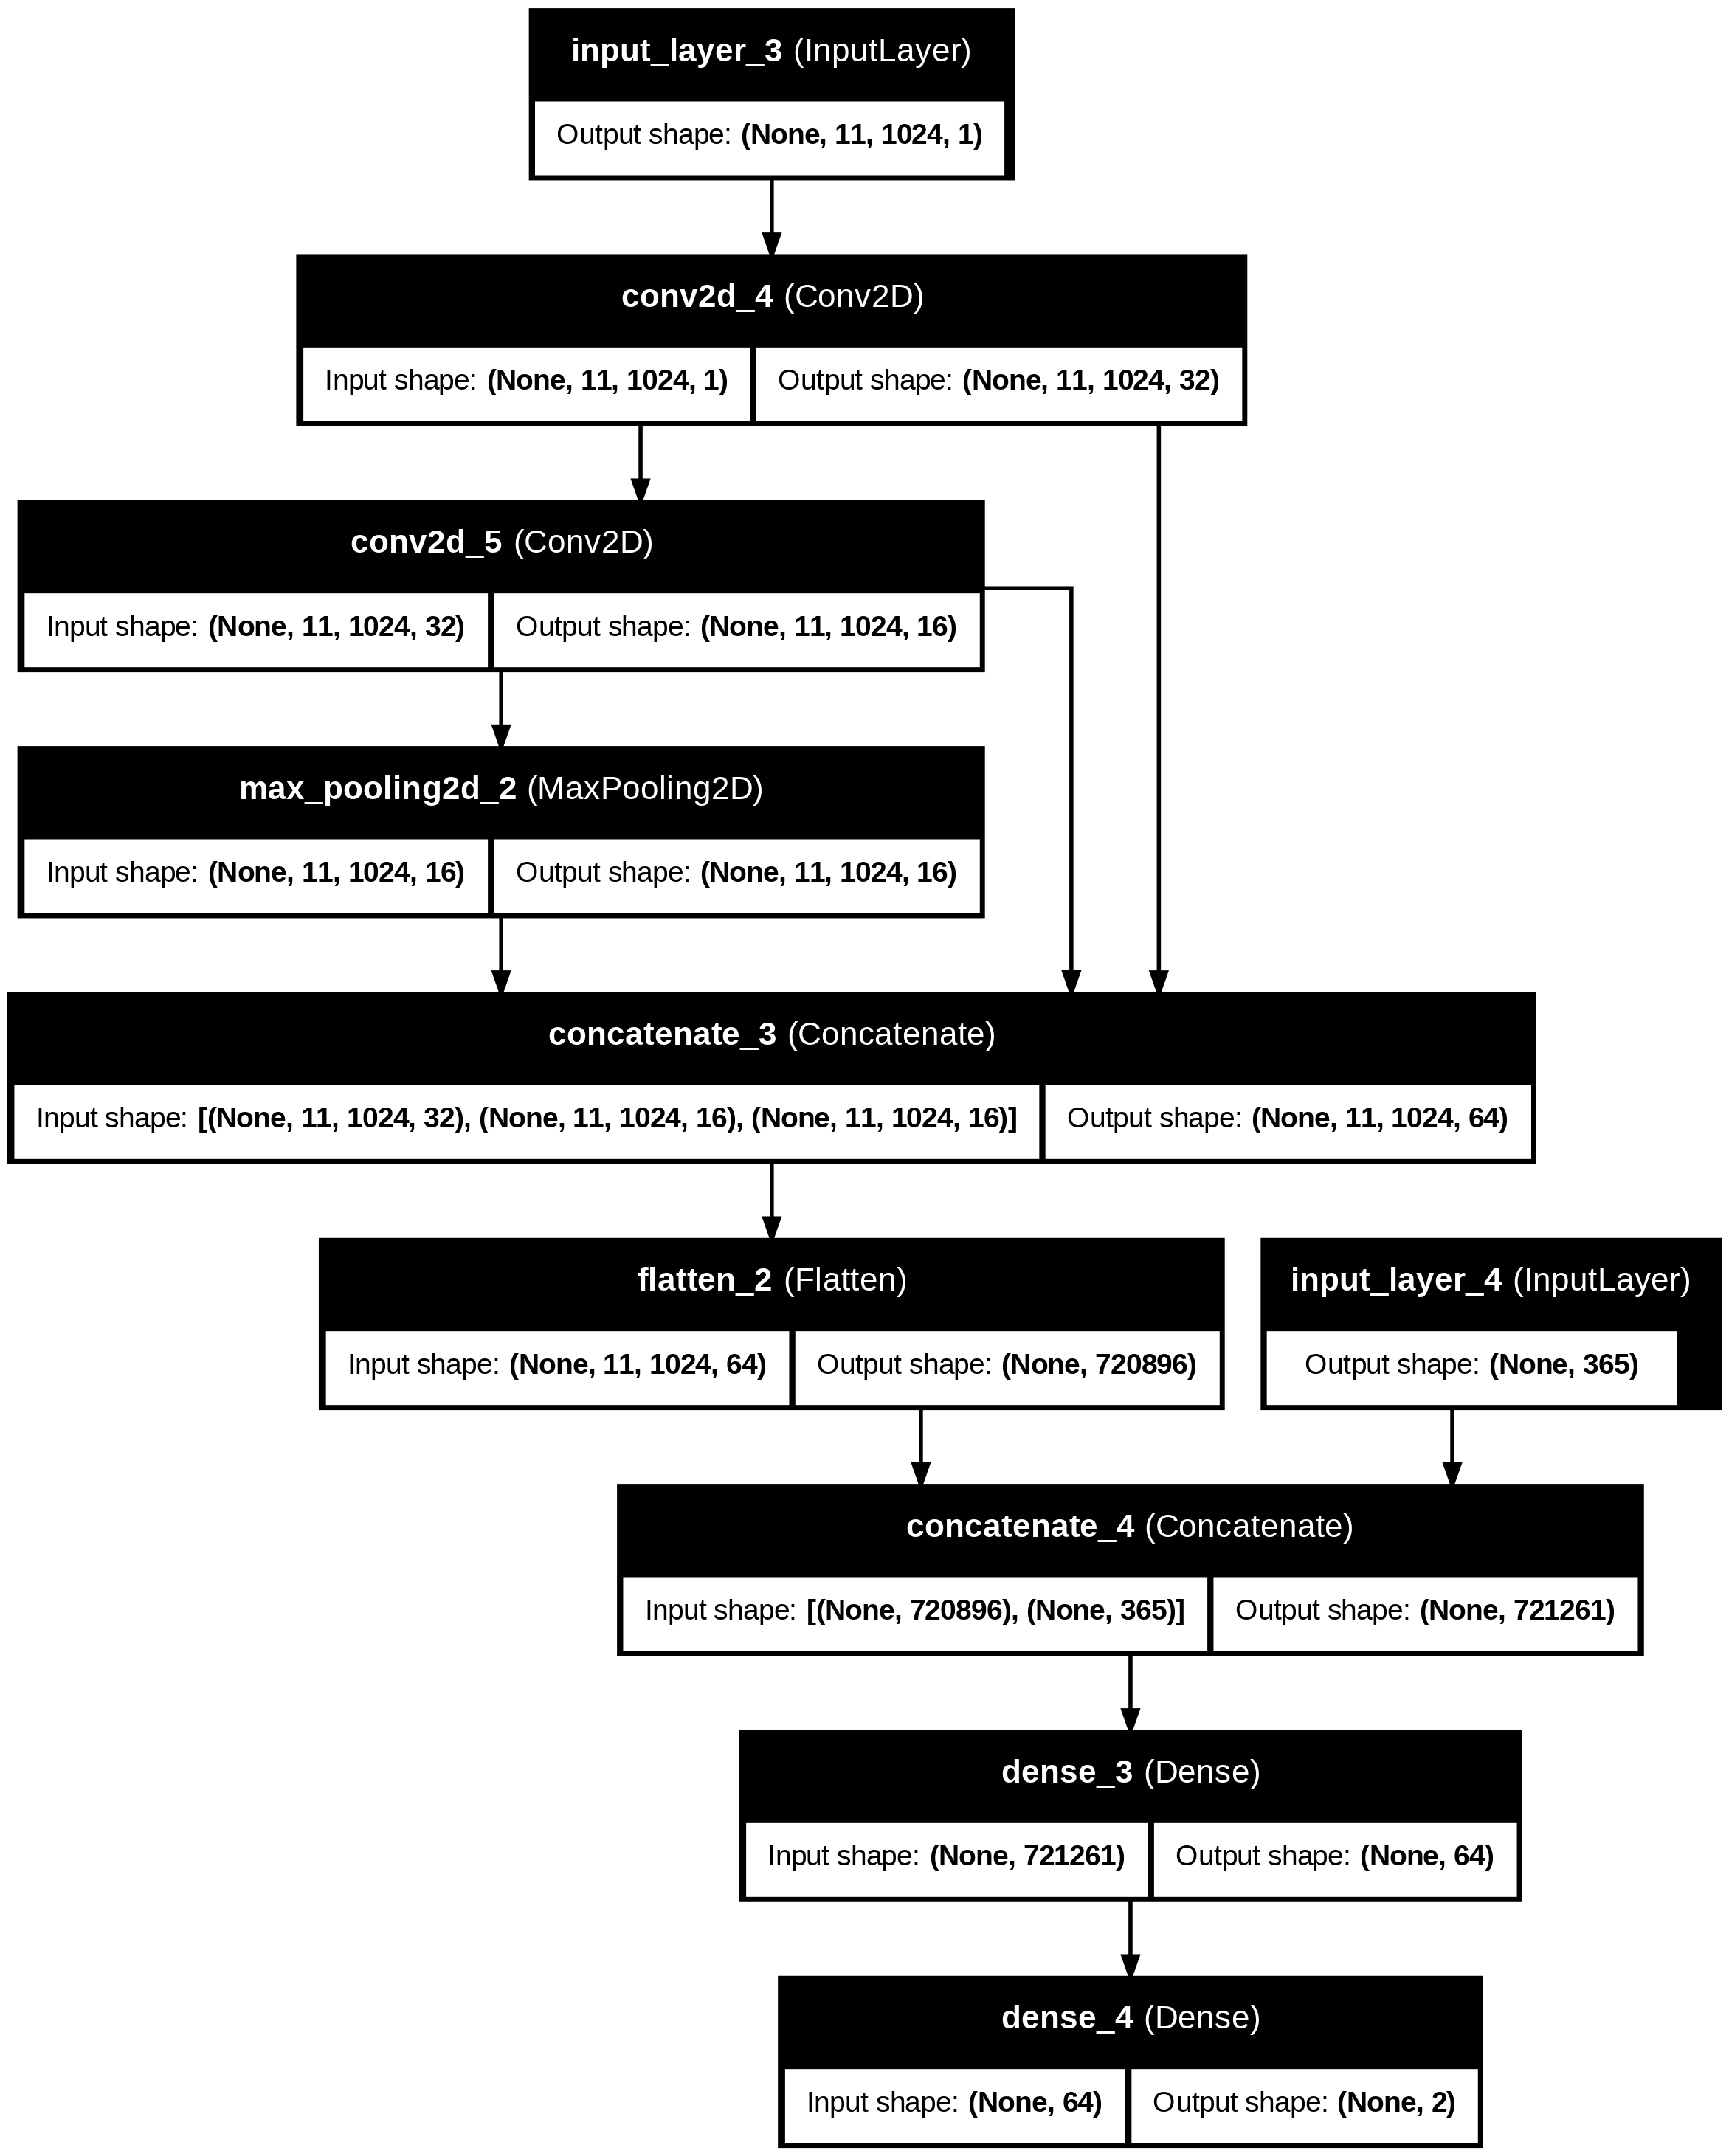

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Concatenate, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from IPython.display import Image


def create_inception_11_final(input_layer):
    # 1x1 conv
    conv1 = Conv2D(32, (1,1), padding='same', activation='relu')(input_layer)
    # 3x3 conv
    conv3 = Conv2D(16, (3,3), padding='same', activation='relu')(conv1)


    # MaxPooling
    pool = MaxPooling2D((2,2), strides=(1,1), padding='same')(conv3)
    # Concatenate filters
    out = Concatenate()([conv1, conv3, pool])
    return out

def inception_11_final(input_shape):
    input_layer = Input(shape=input_shape)
    x = create_inception_11_final(input_layer)
    cnn_out = Flatten()(x)

    extra_features_input = Input(shape=(365,))

    combined = Concatenate()([cnn_out, extra_features_input])
    combined_out = Dense(64, activation='relu')(combined)
    final_output = Dense(2, activation='softmax')(combined_out)

    my_adam = Adam(learning_rate=0.00005)
    model = Model(inputs=[input_layer, extra_features_input], outputs=final_output)
    model.compile(optimizer=my_adam, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

# Define model
input_shape = (11, 1024, 1)
model = inception_11_final(input_shape)

# Plot the model and save to file
plot_model(model, to_file='model_diagram.png', show_shapes=True, show_layer_names=True)

# Display the model diagram
Image('model_diagram.png')


##iTTCA-RF (Random forest with chemical features)

In [ ]:
#ittca features random forest
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from sklearn.metrics import accuracy_score, classification_report


rf_classifier = RandomForestClassifier(max_depth= 20, min_samples_leaf= 1, min_samples_split= 3, n_estimators= 200, random_state=0)
rf_classifier.fit(ittca_features_train, y_train)
y_pred = rf_classifier.predict(ittca_features_test)
y_prob = rf_classifier.predict_proba(ittca_features_test)[:, 1]


accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("Classification Report:\n", classification_rep)



fpr3, tpr3, thresholds = roc_curve(y_test, y_prob)
auc3 = roc_auc_score(y_test, y_prob)
print('AUC: %0.2f' % auc3)


Accuracy: 0.864406779661017
Classification Report:
               precision    recall  f1-score   support

       False       0.88      0.84      0.86       118
        True       0.85      0.89      0.87       118

    accuracy                           0.86       236
   macro avg       0.87      0.86      0.86       236
weighted avg       0.87      0.86      0.86       236

AUC: 0.94


In [ ]:
ittca_features_test.shape

(236, 365)

#Scaled Chemical Features Random Forest

In [ ]:
"""
#ittca features random forest with scaled features kullanılmayacak
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from sklearn.metrics import accuracy_score, classification_report


rf_classifier = RandomForestClassifier(random_state=0)
rf_classifier.fit(ittca_features_train_scaled, y_train)
y_pred = rf_classifier.predict(ittca_features_test_scaled)



accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("Classification Report:\n", classification_rep)

fpr4, tpr4, thresholds = roc_curve(y_test, y_pred[:, 1])
auc4 = roc_auc_score(y_test, y_prob11[:, 1])
print('AUC: %0.2f' % auc4)
"""

'\n#ittca features random forest with scaled features kullanılmayacak\nfrom sklearn.ensemble import RandomForestClassifier\nimport numpy as np\nfrom sklearn.metrics import accuracy_score, classification_report\n\n\nrf_classifier = RandomForestClassifier(random_state=0)\nrf_classifier.fit(ittca_features_train_scaled, y_train)\ny_pred = rf_classifier.predict(ittca_features_test_scaled)\n\n\n\naccuracy = accuracy_score(y_test, y_pred)\nclassification_rep = classification_report(y_test, y_pred)\n\nprint("Accuracy:", accuracy)\nprint("Classification Report:\n", classification_rep)\n\nfpr4, tpr4, thresholds = roc_curve(y_test, y_pred[:, 1])\nauc4 = roc_auc_score(y_test, y_prob11[:, 1])\nprint(\'AUC: %0.2f\' % auc4)\n'

###X_flatten

In [ ]:

lengths_train = [len(seq) for seq in X_train]


max_length_train = max(lengths_train)


lengths_test = [len(seq) for seq in X_test]


max_length_test = max(lengths_test)


max_length = max(max_length_train, max_length_test)

def pad_and_flatten(sequences, max_length):
    padded_sequences = []
    for seq in sequences:
        # Fill the array with padding
        padding_length = max_length - len(seq)
        # Fill with zero vectors
        padded_seq = np.concatenate([seq, np.zeros((padding_length, seq.shape[1]))], axis=0)
        # Flattened version
        flattened_seq = padded_seq.flatten()
        padded_sequences.append(flattened_seq)
    return np.array(padded_sequences)

X_train_flat = pad_and_flatten(X_train, max_length)
X_test_flat = pad_and_flatten(X_test, max_length)

print(len(X_train))
print(X_train_flat.shape)


788
(788, 51200)


# RF + DeepFeatures Stdevs

In [ ]:
#ProtBERT features + stdevs -> 2048 feature , random forest hyperparameter tuned
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

param_grid = {
    'n_estimators': [150],
    'max_depth': [10],
    'min_samples_split': [3]
}
"""
param_grid = {
    'n_estimators': [100, 150, 200],
    'max_depth': [10, 15, 20],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [1, 2, 3]
}"""

rf = RandomForestClassifier(random_state=0)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_final, y_train)

print("Best Params: ", grid_search.best_params_)
best_rf_model = grid_search.best_estimator_
y_pred1 = best_rf_model.predict(X_test_final)
y_prob1 = best_rf_model.predict_proba(X_test_final)[:, 1]
classification_rep = classification_report(y_test, y_pred1)
print(classification_rep)

fpr6, tpr6, thresholds = roc_curve(y_test, y_prob1)
auc6 = roc_auc_score(y_test, y_prob1)
print('AUC: %0.2f' % auc6)
#kendi featurelarımız + stdev ler 2048 feature , random forest hyperparameter tuned

Best Params:  {'max_depth': 10, 'min_samples_split': 3, 'n_estimators': 150}
              precision    recall  f1-score   support

       False       0.77      0.81      0.79       118
        True       0.79      0.75      0.77       118

    accuracy                           0.78       236
   macro avg       0.78      0.78      0.78       236
weighted avg       0.78      0.78      0.78       236

AUC: 0.83


In [ ]:
"""
#ittca random forest hyperparameter tuned
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report



param_grid = {
    'n_estimators': [100, 150, 200],
    'max_depth': [10, 15, 20],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [1, 2, 3]
}


rf = RandomForestClassifier(random_state=0)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(ittca_features_train_scaled, y_train)

print("En iyi parametreler: ", grid_search.best_params_)
#print("En iyi doğruluk skoru: ", grid_search.best_score_)


# En iyi modeli alın
best_rf_model = grid_search.best_estimator_



y_pred = best_rf_model.predict(ittca_features_test_scaled)
classification_rep = classification_report(y_test, y_pred)

print(classification_rep)

fpr7, tpr7, thresholds = roc_curve(y_test, y_prob11[:, 1])
auc7 = roc_auc_score(y_test, y_prob11[:, 1])
print('AUC: %0.2f' % auc7)
#ittca random forest hyperparameter tuned
"""

'\n#ittca random forest hyperparameter tuned\nfrom sklearn.model_selection import GridSearchCV\nfrom sklearn.ensemble import RandomForestClassifier\nfrom sklearn.metrics import accuracy_score, classification_report\n\n\n\nparam_grid = {\n    \'n_estimators\': [100, 150, 200],\n    \'max_depth\': [10, 15, 20],\n    \'min_samples_split\': [2, 3, 4],\n    \'min_samples_leaf\': [1, 2, 3]\n}\n\n\nrf = RandomForestClassifier(random_state=0)\ngrid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring=\'accuracy\')\ngrid_search.fit(ittca_features_train_scaled, y_train)\n\nprint("En iyi parametreler: ", grid_search.best_params_)\n#print("En iyi doğruluk skoru: ", grid_search.best_score_)\n\n\n# En iyi modeli alın\nbest_rf_model = grid_search.best_estimator_\n\n\n\ny_pred = best_rf_model.predict(ittca_features_test_scaled)\nclassification_rep = classification_report(y_test, y_pred)\n\nprint(classification_rep)\n\nfpr7, tpr7, thresholds = roc_curve(y_test, y_prob11[:, 1])\nauc7

In [ ]:
"""
#ittca xgboost hyperparameter tuned
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report

param_grid_xgb = {
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 150, 200],
    'max_depth': [3, 6, 9],
    'colsample_bytree': [0.5, 0.7, 1.0]
}


xgb = XGBClassifier(random_state=42)
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid_xgb, cv=5, scoring='accuracy')
grid_search.fit(ittca_features_train, y_train)

print("En iyi parametreler: ", grid_search.best_params_)

best_xgb_model = grid_search.best_estimator_

y_pred = best_xgb_model.predict(ittca_features_test)
classification_rep = classification_report(y_test, y_pred)

print(classification_rep)

"""

'\n#ittca xgboost hyperparameter tuned\nfrom xgboost import XGBClassifier\nfrom sklearn.model_selection import GridSearchCV\nfrom sklearn.metrics import accuracy_score, classification_report\n\nparam_grid_xgb = {\n    \'learning_rate\': [0.01, 0.1, 0.2],\n    \'n_estimators\': [100, 150, 200],\n    \'max_depth\': [3, 6, 9],\n    \'colsample_bytree\': [0.5, 0.7, 1.0]\n}\n\n\nxgb = XGBClassifier(random_state=42)\ngrid_search = GridSearchCV(estimator=xgb, param_grid=param_grid_xgb, cv=5, scoring=\'accuracy\')\ngrid_search.fit(ittca_features_train, y_train)\n\nprint("En iyi parametreler: ", grid_search.best_params_)\n\nbest_xgb_model = grid_search.best_estimator_\n\ny_pred = best_xgb_model.predict(ittca_features_test)\nclassification_rep = classification_report(y_test, y_pred)\n\nprint(classification_rep)\n\n'

## DeepT-RF (Random Forest with deep features from ProtBERT)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

rf_classifier = RandomForestClassifier(
    n_estimators=150,
    max_depth=15,
    min_samples_split=3,
    random_state=56
)


rf_classifier.fit(X_train_flat, y_train)

y_pred = rf_classifier.predict(X_test_flat)
y_prob_rf = rf_classifier.predict_proba(X_test_flat)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
print("Güncellenmiş Random Forest sınıflandırıcısının doğruluğu:", accuracy)


print(classification_report(y_test, y_pred))

fpr5, tpr5, thresholds = roc_curve(y_test, y_prob_rf)
auc5 = roc_auc_score(y_test, y_prob_rf)
print('AUC: %0.2f' % auc5)


Güncellenmiş Random Forest sınıflandırıcısının doğruluğu: 0.864406779661017
              precision    recall  f1-score   support

       False       0.91      0.81      0.86       118
        True       0.83      0.92      0.87       118

    accuracy                           0.86       236
   macro avg       0.87      0.86      0.86       236
weighted avg       0.87      0.86      0.86       236

AUC: 0.94


In [ ]:
"""
#ProtBERT features + stdevs -> 2048 feature , xgboost hyperparameter tuned
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report

param_grid_xgb = {
    'learning_rate': [0.01, 0.1],
    'n_estimators': [100, 150],
    'max_depth': [3, 6]
}

param_grid_xgb = {
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 150, 200],
    'max_depth': [3, 6, 9],
    'colsample_bytree': [0.5, 0.7, 1.0]
}

xgb = XGBClassifier(random_state=42)
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid_xgb, cv=5, scoring='accuracy')
grid_search.fit(X_train_final, y_train)

print("En iyi parametreler: ", grid_search.best_params_)


best_xgb_model = grid_search.best_estimator_

y_pred = best_xgb_model.predict(X_test_final)
classification_rep = classification_report(y_test, y_pred)

print(classification_rep)
"""

'\n#ProtBERT features + stdevs -> 2048 feature , xgboost hyperparameter tuned\nfrom xgboost import XGBClassifier\nfrom sklearn.model_selection import GridSearchCV\nfrom sklearn.metrics import accuracy_score, classification_report\n\nparam_grid_xgb = {\n    \'learning_rate\': [0.01, 0.1],\n    \'n_estimators\': [100, 150],\n    \'max_depth\': [3, 6]\n}\n\nparam_grid_xgb = {\n    \'learning_rate\': [0.01, 0.1, 0.2],\n    \'n_estimators\': [100, 150, 200],\n    \'max_depth\': [3, 6, 9],\n    \'colsample_bytree\': [0.5, 0.7, 1.0]\n}\n\nxgb = XGBClassifier(random_state=42)\ngrid_search = GridSearchCV(estimator=xgb, param_grid=param_grid_xgb, cv=5, scoring=\'accuracy\')\ngrid_search.fit(X_train_final, y_train)\n\nprint("En iyi parametreler: ", grid_search.best_params_)\n\n\nbest_xgb_model = grid_search.best_estimator_\n\ny_pred = best_xgb_model.predict(X_test_final)\nclassification_rep = classification_report(y_test, y_pred)\n\nprint(classification_rep)\n'

## DeepT-XGB (XGBoost with deep features from ProtBERT)

XGBoost sınıflandırıcısının doğruluğu: 0.8601694915254238
              precision    recall  f1-score   support

       False       0.86      0.86      0.86       118
        True       0.86      0.86      0.86       118

    accuracy                           0.86       236
   macro avg       0.86      0.86      0.86       236
weighted avg       0.86      0.86      0.86       236

AUC: 0.94


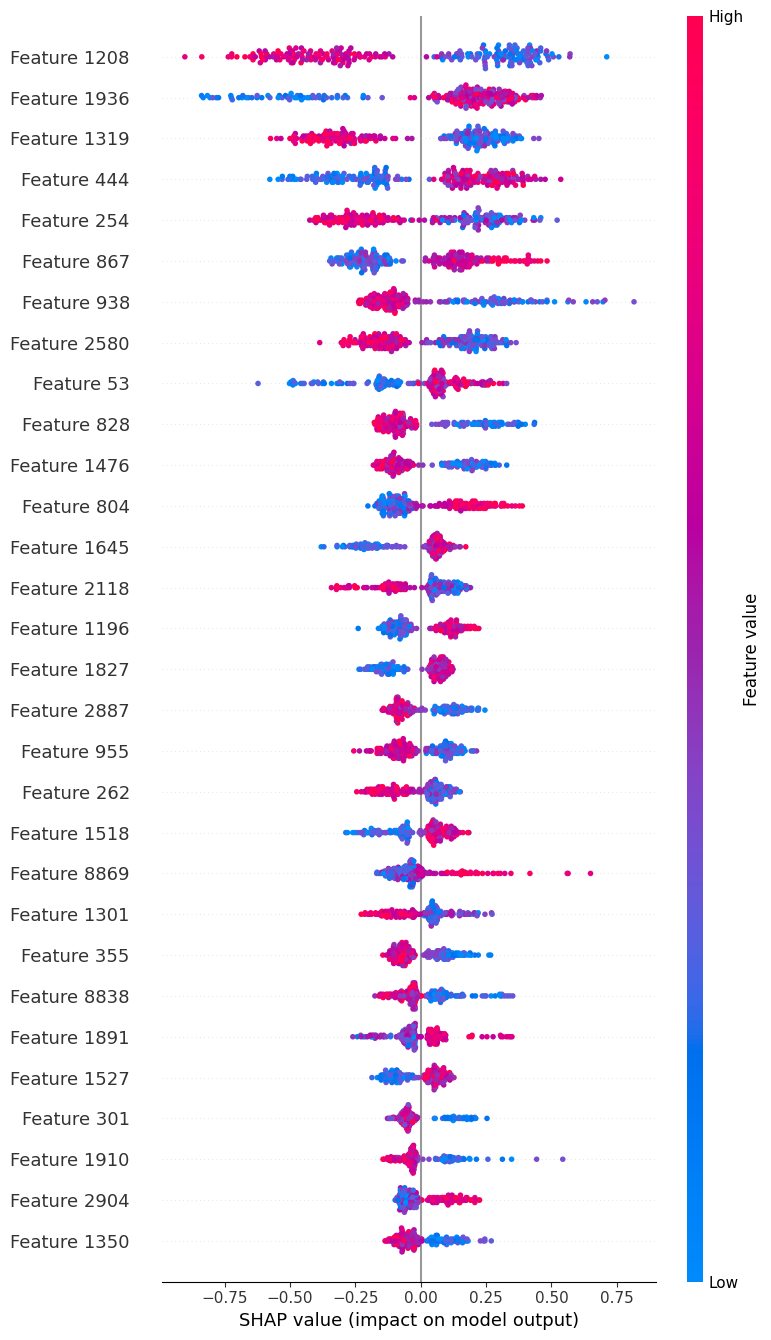

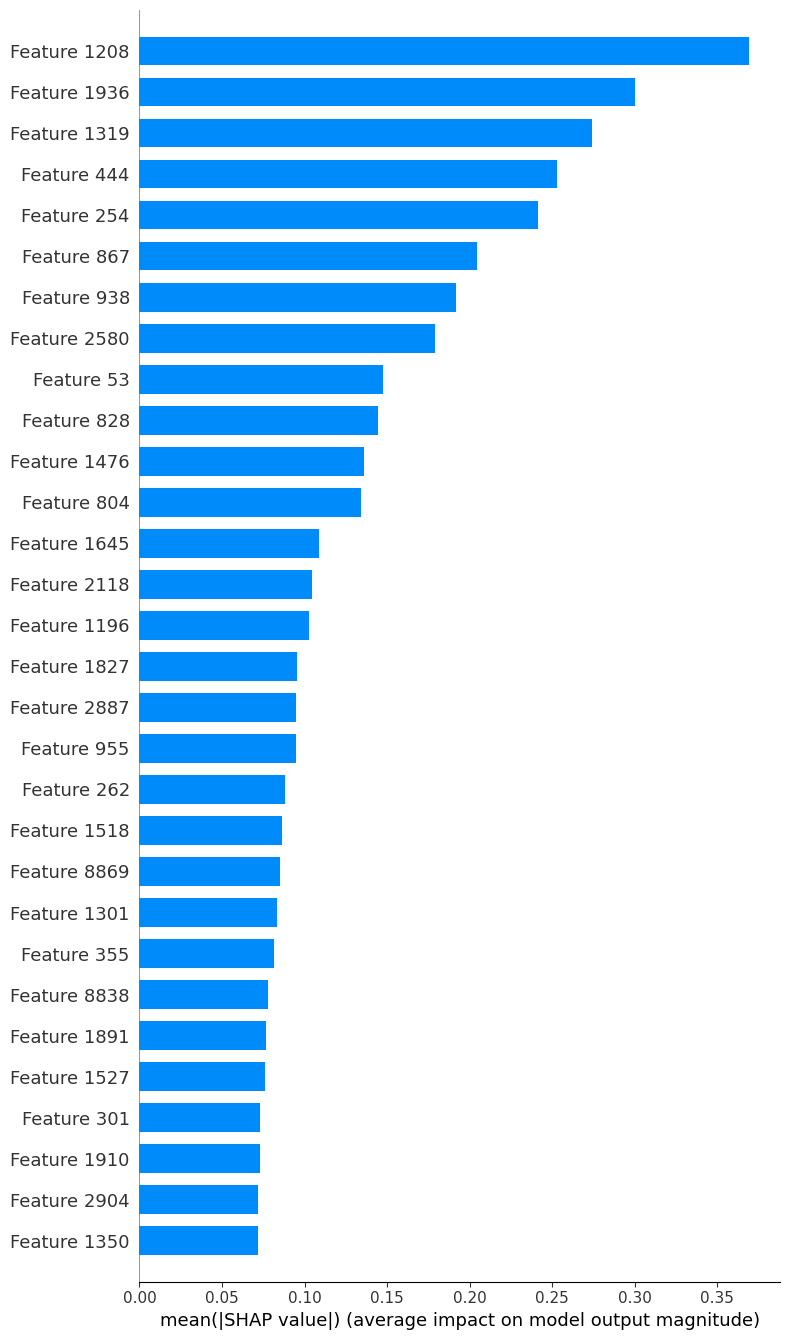

In [ ]:
import xgboost as xgb
!pip install shap
import shap


xgb_classifier = xgb.XGBClassifier(random_state=42, learning_rate = 0.1, n_estimators = 150, max_depth = 9 )

xgb_classifier.fit(X_train_flat, y_train)

y_pred_xgb = xgb_classifier.predict(X_test_flat)

accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print("XGBoost sınıflandırıcısının doğruluğu:", accuracy_xgb)
y_prob_xgb = xgb_classifier.predict_proba(X_test_flat)[:, 1]

print(classification_report(y_test, y_pred_xgb))

fpr8, tpr8, thresholds = roc_curve(y_test, y_prob_xgb)
auc8 = roc_auc_score(y_test, y_prob_xgb)
print('AUC: %0.2f' % auc8)


# SHAP analysis
explainer = shap.TreeExplainer(xgb_classifier)
shap_values = explainer.shap_values(X_test_flat)

# Adjust plot size and generate summary plot
plt.figure(figsize=(12, 8))  # Adjust the size as needed
shap.summary_plot(shap_values, X_test_flat, max_display=30)  # Show 30 features

# Adjust plot size and generate feature importance bar plot
plt.figure(figsize=(12, 8))  # Adjust the size as needed
shap.summary_plot(shap_values, X_test_flat, plot_type="bar", max_display=30)  # Show 30 features


## XGB HYBRID Features

XGBoost sınıflandırıcısının doğruluğu: 0.7563451776649747
              precision    recall  f1-score   support

       False       0.91      0.40      0.56        75
        True       0.73      0.98      0.83       122

    accuracy                           0.76       197
   macro avg       0.82      0.69      0.69       197
weighted avg       0.80      0.76      0.73       197

AUC: 0.79


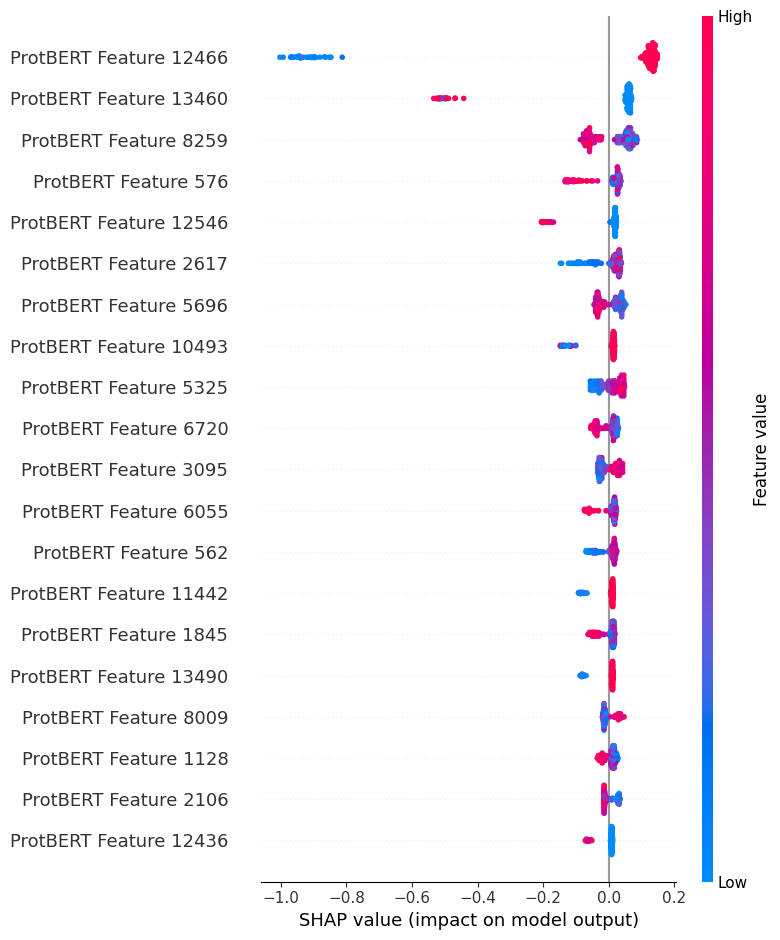

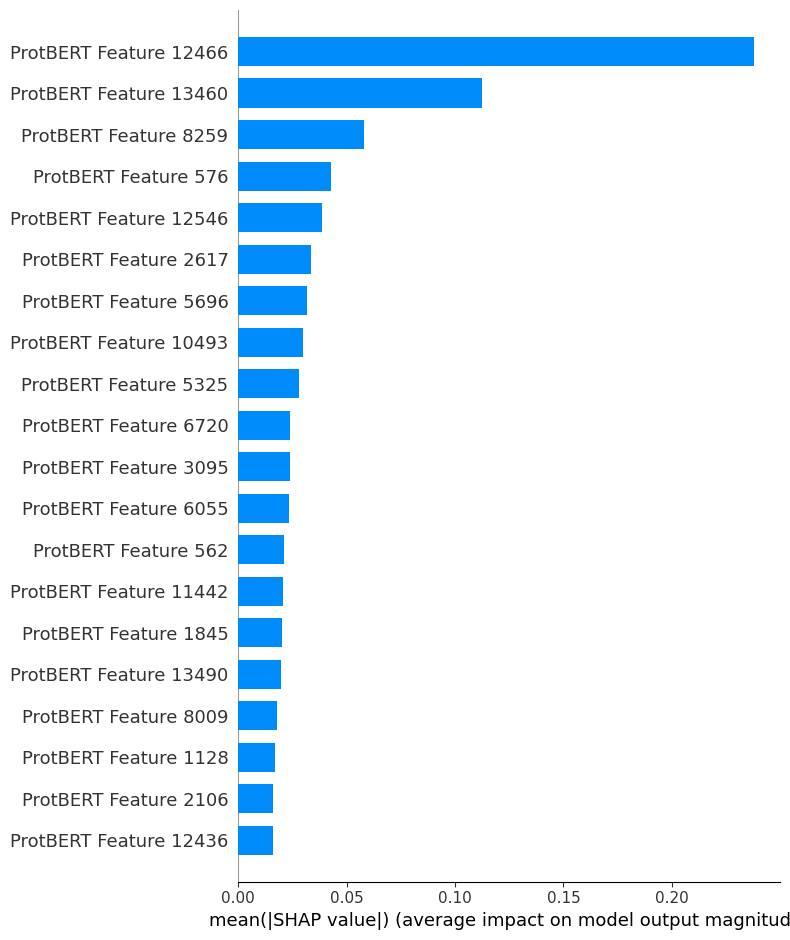

In [ ]:
#Hybrid features xgboost

x_hybrid_train = np.concatenate((X_train_flat, ittca_features_train_scaled), axis=1)
x_hybrid_test = np.concatenate((X_test_flat, ittca_features_test_scaled), axis=1)

x_hybrid_train.shape

import xgboost as xgb
import shap


xgb_classifier = xgb.XGBClassifier(random_state=42, colsample_bytree= 0.8, learning_rate= 0.01, max_depth= 3, n_estimators=200, subsample= 0.8) # colsample_bytree= 0.8, learning_rate= 0.01, max_depth= 6, n_estimators= 200, subsample= 0.9) 90.2
#{'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 100, 'subsample': 0.8} 91.52 human dataset 2
#{'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8} 75.6 human dataset 1

xgb_classifier.fit(x_hybrid_train, y_train)

y_pred_xgb = xgb_classifier.predict(x_hybrid_test)

accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print("XGBoost sınıflandırıcısının doğruluğu:", accuracy_xgb)
y_prob_xgb = xgb_classifier.predict_proba(x_hybrid_test)[:, 1]

print(classification_report(y_test, y_pred_xgb))

fpr8, tpr8, thresholds = roc_curve(y_test, y_prob_xgb)
auc8 = roc_auc_score(y_test, y_prob_xgb)
print('AUC: %0.2f' % auc8)

# SHAP analysis
explainer = shap.TreeExplainer(xgb_classifier)
shap_values = explainer.shap_values(x_hybrid_test)

# Create feature names
deep_feature_names = [f'ProtBERT Feature {i}' for i in range(20480)]
chemical_feature_names = get_feature_names()
hybrid_feature_names = deep_feature_names + chemical_feature_names

# Adjust plot size and generate summary plot
plt.figure(figsize=(12, 8))  # Adjust the size as needed
shap.summary_plot(shap_values, x_hybrid_test, feature_names=hybrid_feature_names)

# Adjust plot size and generate feature importance bar plot
plt.figure(figsize=(12, 8))  # Adjust the size as needed
shap.summary_plot(shap_values, x_hybrid_test, feature_names=hybrid_feature_names, plot_type="bar")



In [ ]:
x_hybrid_train.shape
X_train_flat.shape


(788, 51200)

In [ ]:
import graphviz
import pydotplus
from xgboost import plot_tree
from IPython.display import Image, display
from subprocess import run

# Assuming xgb_classifier is already trained

# Generate the first decision tree visualization
dot_data = xgb.to_graphviz(xgb_classifier, num_trees=0)

# Convert the dot data to string and adjust line width and font size
dot_string = dot_data.source.replace('fontsize=14', 'fontsize=24').replace('penwidth=1', 'penwidth=5')

# Ensure that penwidth is set properly if not already present
dot_string = dot_string.replace('edge [', 'edge [penwidth=5,')
dot_string = dot_string.replace('node [', 'node [penwidth=5,')

# Create a graph from the modified dot string
graph = pydotplus.graph_from_dot_data(dot_string)

# Save the dot file
graph.write('xgb_tree_high_dpi.dot')

# Use Graphviz to convert the dot file to a high DPI PNG
run(['dot', '-Tpng', 'xgb_tree_high_dpi.dot', '-o', 'xgb_tree_high_dpi.png', '-Gdpi=500'])

# Load and display the image
img = Image(filename='xgb_tree_high_dpi.png')
display(img)


In [ ]:
import xgboost as xgb
import graphviz
import pydotplus
from subprocess import run

# Assuming xgb_classifier is already trained
# If not, you need to train it as shown below
# iris = datasets.load_iris()
# X = iris.data
# y = iris.target
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# xgb_classifier = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
# xgb_classifier.fit(X_train, y_train)

# Generate the first decision tree visualization
dot_data = xgb.to_graphviz(xgb_classifier, num_trees=0)

# Convert the dot data to string and adjust line width and font size
dot_string = dot_data.source.replace('fontsize=16', 'fontsize=40').replace('penwidth=2', 'penwidth=10')

# Ensure that penwidth is set properly if not already present
dot_string = dot_string.replace('edge [', 'edge [penwidth=10,')
dot_string = dot_string.replace('node [', 'node [penwidth=10,')

# Create a graph from the modified dot string
graph = pydotplus.graph_from_dot_data(dot_string)

# Save the dot file
graph.write('xgb_tree_high_dpi.dot')

# Use Graphviz to convert the dot file to an SVG with specified dimensions
run(['dot', '-Tsvg', 'xgb_tree_high_dpi.dot', '-o', 'xgb_tree_high_dpi.svg', '-Gsize=7.52,1.00!'])

print("SVG file saved as 'xgb_tree_high_dpi.svg'")


SVG file saved as 'xgb_tree_high_dpi.svg'


In [ ]:
import xgboost as xgb
import matplotlib.pyplot as plt

# Assuming xgb_classifier is already trained
plt.figure(figsize=(100, 30))  # Large figure size for clarity
ax = plt.subplot(1, 1, 1)
ax.axis('off')  # Turn off the axis

# Plot the tree with specific Graphviz options
xgb.plot_tree(xgb_classifier, num_trees=0, rankdir='LR', ax=ax,
              show_node_labels=True, fontsize=10,
              graph_attrs={'nodesep': '0.1', 'ranksep': '0.1', 'bgcolor': 'transparent'},
              edge_attrs={'color': '#000000', 'penwidth': '2'})  # Thicker lines and black color

plt.subplots_adjust(left=0, right=1, top=1, bottom=0)  # Adjust the plot margins

# Save the figure with high DPI
plt.savefig('xgboost_tree_optimized.png', dpi=600, bbox_inches='tight', pad_inches=0)
plt.close()  # Close the plot to free up memory


In [ ]:
import numpy as np
import xgboost as xgb
import shap
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, roc_curve, roc_auc_score

# Assuming your X_hybrid arrays and y_train, y_test are already defined
x_hybrid_train = np.concatenate((X_train_flat, ittca_features_train_scaled), axis=1)
x_hybrid_test = np.concatenate((X_test_flat, ittca_features_test_scaled), axis=1)

x_hybrid_train.shape

# Define and train the XGBoost classifier
xgb_classifier = xgb.XGBClassifier(random_state=42, colsample_bytree=0.8, learning_rate=0.01, max_depth=6, n_estimators=200, subsample=0.9)
xgb_classifier.fit(x_hybrid_train, y_train)

# Make predictions
y_pred_xgb = xgb_classifier.predict(x_hybrid_test)
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print("XGBoost classifier accuracy:", accuracy_xgb)

# Print classification report
print(classification_report(y_test, y_pred_xgb))

# Compute ROC curve and AUC score
y_prob_xgb = xgb_classifier.predict_proba(x_hybrid_test)[:, 1]
fpr8, tpr8, thresholds = roc_curve(y_test, y_prob_xgb)
auc8 = roc_auc_score(y_test, y_prob_xgb)
print('AUC: %0.2f' % auc8)

# Initialize the SHAP explainer
explainer = shap.TreeExplainer(xgb_classifier)
shap_values = explainer.shap_values(x_hybrid_test)

# Extract the chemical features (20480 to 20845)
chemical_features = x_hybrid_test[:, 20480:20845]
chemical_shap_values = shap_values[:, 20480:20845]



# Adjust plot size and generate summary plot for chemical features
plt.figure(figsize=(12, 8))
shap.summary_plot(chemical_shap_values, chemical_features, feature_names=feature_names)

# Adjust plot size and generate feature importance bar plot for chemical features
plt.figure(figsize=(12, 8))
shap.summary_plot(chemical_shap_values, chemical_features, feature_names=feature_names, plot_type="bar")


In [ ]:
# Initialize the SHAP explainer
explainer = shap.TreeExplainer(xgb_classifier)
shap_values = explainer.shap_values(x_hybrid_test)

# Extract the chemical features (20480 to 20845)
chemical_features = x_hybrid_test[:, 20480:20845]
chemical_shap_values = shap_values[:, 20480:20845]

# Create a feature names list for SHAP plot with original indices
feature_names = [f'Feature {i}' for i in range(20480, 20845)]

# Adjust plot size and generate summary plot for chemical features
plt.figure(figsize=(12, 8))
shap.summary_plot(chemical_shap_values, chemical_features, feature_names=feature_names)

# Adjust plot size and generate feature importance bar plot for chemical features
plt.figure(figsize=(12, 8))
shap.summary_plot(chemical_shap_values, chemical_features, feature_names=feature_names, plot_type="bar")

In [ ]:
"""!pip install shap

import shap
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, roc_curve
import time



# Define the best parameters found
best_params = {
    'n_estimators': 300,
    'max_depth': 10,
    'min_samples_split': 10,
    'min_samples_leaf': 2,
    'bootstrap': False
}

# Train the classifier with the best parameters
best_rf_classifier = RandomForestClassifier(**best_params, random_state=56)
best_rf_classifier.fit(x_hybrid_train, y_train)

# Predict using the test data
y_pred = best_rf_classifier.predict(x_hybrid_test)
accuracy = accuracy_score(y_test, y_pred)
print("Updated Random Forest classifier accuracy:", accuracy)

# Print classification report
print(classification_report(y_test, y_pred))

# Calculate AUC
y_prob_rf = best_rf_classifier.predict_proba(x_hybrid_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob_rf)
auc = roc_auc_score(y_test, y_prob_rf)
print('AUC: %0.2f' % auc)

# SHAP analysis
explainer = shap.Explainer(best_rf_classifier, x_hybrid_train)
shap_values = explainer(x_hybrid_test)

# Summary plot
shap.summary_plot(shap_values, x_hybrid_test)

# Feature importance bar plot
shap.summary_plot(shap_values, x_hybrid_test, plot_type="bar")
"""

## DeepT-HybridRF (RF HYBRİD FEATURES)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

rf_classifier = RandomForestClassifier(bootstrap=False, max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=300, random_state=56)


rf_classifier.fit(x_hybrid_train, y_train)

y_pred = rf_classifier.predict(x_hybrid_test)
y_prob_rf = rf_classifier.predict_proba(x_hybrid_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
print("Güncellenmiş Random Forest sınıflandırıcısının doğruluğu:", accuracy)


print(classification_report(y_test, y_pred))

fpr5, tpr5, thresholds = roc_curve(y_test, y_prob_rf)
auc5 = roc_auc_score(y_test, y_prob_rf)
print('AUC: %0.2f' % auc5)

## DeepT-HybridRF hyperparameter tuning

In [ ]:
# %90.6 accuracy

import time
import numpy as np
from sklearn.model_selection import ParameterGrid
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, roc_curve

# Zamanlayıcıyı başlat
start_time = time.time()

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

best_params = None
best_score = 0
iteration = 0

# Her parametre kombinasyonunu deneyin
for params in ParameterGrid(param_grid):
    iteration += 1
    print(f"Iteration {iteration}: Testing parameters: {params}")

    rf_classifier = RandomForestClassifier(**params, random_state=56)
    rf_classifier.fit(x_hybrid_train, y_train)

    y_pred = rf_classifier.predict(x_hybrid_test)
    score = accuracy_score(y_test, y_pred)

    print(f"Iteration {iteration}: Accuracy: {score}")

    if score > best_score:
        best_score = score
        best_params = params

# En iyi parametrelerle eğitim
print("En iyi hyperparameterlar:", best_params)
best_rf_classifier = RandomForestClassifier(**best_params, random_state=56)
best_rf_classifier.fit(x_hybrid_train, y_train)

# Tahmin ve sonuçlar
y_pred = best_rf_classifier.predict(x_hybrid_test)
accuracy = accuracy_score(y_test, y_pred)
y_prob_rf = best_rf_classifier.predict_proba(x_hybrid_test)[:, 1]

print("Güncellenmiş Random Forest sınıflandırıcısının doğruluğu:", accuracy)
print(classification_report(y_test, y_pred))

# AUC hesaplama
fpr, tpr, thresholds = roc_curve(y_test, y_prob_rf)
auc = roc_auc_score(y_test, y_prob_rf)
print('AUC: %0.2f' % auc)

# Zamanlayıcıyı durdur ve süreyi yazdır
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Model eğitimi ve tuning süresi: {elapsed_time:.2f} saniye")


## DeepT-HybridXGB HYPERparameter tuning

In [ ]:
import numpy as np
import xgboost as xgb
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import accuracy_score, classification_report
import time

# Zamanlayıcıyı başlat
start_time = time.time()

# Verileri birleştirme
x_hybrid_train = np.concatenate((X_train_flat, ittca_features_train_scaled), axis=1)
x_hybrid_test = np.concatenate((X_test_flat, ittca_features_test_scaled), axis=1)

# XGBoost sınıflandırıcısı ve hyperparameter tuning için parametreler

"""param_grid = {
    'max_depth': [4, 5, 6, 7],
    'learning_rate': [0.005, 0.01, 0.02],
    'n_estimators': [160, 180, 200, 220],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.85],
    'subsample': [0.75, 0.8, 0.85, 0.9]
}""" #en iyi sonuclar

param_grid = {
    'n_estimators': [100, 150, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}


best_params = None
best_score = 0
iteration = 0

# Her parametre kombinasyonunu deneyin
for params in ParameterGrid(param_grid):
    iteration += 1
    print(f"Iteration {iteration}: Testing parameters: {params}")

    xgb_classifier = xgb.XGBClassifier(**params, random_state=42)
    xgb_classifier.fit(x_hybrid_train, y_train)

    y_pred = xgb_classifier.predict(x_hybrid_test)
    score = accuracy_score(y_test, y_pred)

    print(f"Iteration {iteration}: Accuracy: {score}")

    if score > best_score:
        best_score = score
        best_params = params

# En iyi parametrelerle eğitim
print("En iyi hyperparameterlar:", best_params)
xgb_classifier_best = xgb.XGBClassifier(**best_params, random_state=42)
xgb_classifier_best.fit(x_hybrid_train, y_train)

# Tahmin ve sonuçlar
y_pred_xgb = xgb_classifier_best.predict(x_hybrid_test)
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
y_prob_xgb = xgb_classifier_best.predict_proba(x_hybrid_test)[:, 1]

print("XGBoost sınıflandırıcısının doğruluğu:", accuracy_xgb)
print(classification_report(y_test, y_pred_xgb))

# Zamanlayıcıyı durdur ve süreyi yazdır
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Model eğitimi ve tuning süresi: {elapsed_time:.2f} saniye")


Iteration 1: Testing parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
Iteration 1: Accuracy: 0.751269035532995
Iteration 2: Testing parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}
Iteration 2: Accuracy: 0.7461928934010152
Iteration 3: Testing parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 150, 'subsample': 0.8}
Iteration 3: Accuracy: 0.751269035532995
Iteration 4: Testing parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 150, 'subsample': 1.0}
Iteration 4: Accuracy: 0.7360406091370558
Iteration 5: Testing parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}
Iteration 5: Accuracy: 0.7563451776649747
Iteration 6: Testing parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estima

KeyboardInterrupt: 

In [ ]:
# colsample_bytree= 1.0, learning_rate= 0.01, max_depth= 5, n_estimators= 100, subsample= 0.8 91

In [ ]:
plt.figure(figsize=(8, 6), dpi=600)
#plt.plot(fpr1, tpr1, label='DeepT-CNN (AUC = %0.2f)' % auc1, linewidth=2)

plt.plot(fpr3, tpr3, label='iTTCA-RF (AUC = %0.2f)' % auc3, linewidth=2)
plt.plot(fpr2, tpr2, label='DeepT-Hybrid (AUC = %0.2f)' % auc2, linewidth=2)
plt.plot(fpr5, tpr5, label='DeepT-HybridRF (AUC = %0.2f)' % auc5, linewidth=2)
plt.plot(fpr8, tpr8, label='DeepT-HybridXGB (AUC = %0.2f)' % auc8, linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', linewidth=2)  # Rastgele şansın eğrisi
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=14, fontweight='bold')
plt.title('Receiver Operating Characteristic', fontsize=16, fontweight='bold')
plt.legend(loc="lower right", fontsize=12, prop={'weight':'bold'})
plt.show()

